In [1]:
# API 키를 환경변수로 관리하기 위한 설정 파일
from dotenv import load_dotenv

# API 키 정보 로드
load_dotenv()
# LangSmith 추적을 설정합니다. https://smith.langchain.com
# !pip install -qU langchain-teddynote
from langchain_teddynote import logging

# 프로젝트 이름을 입력합니다.
logging.langsmith("CH17-LangGraph-Structures")

LangSmith 추적을 시작합니다.
[프로젝트명]
CH17-LangGraph-Structures


In [2]:
from rag.pdf import PDFRetrievalChain

# PDF 문서를 로드합니다.
pdf = PDFRetrievalChain(["data/SPRI_AI_Brief_2023년12월호_F.pdf"]).create_chain()

# retriever 생성
pdf_retriever = pdf.retriever

# chain 생성
pdf_chain = pdf.chain

### 쿼리 라우팅과 문서 평가

In [3]:
from typing import Literal

from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI
from langchain_teddynote.models import get_model_name, LLMs

# 최신 LLM 모델 이름 가져오기
MODEL_NAME = get_model_name(LLMs.GPT4)


# 사용자 쿼리를 가장 관련성 높은 데이터 소스로 라우팅하는 데이터 모델
class RouteQuery(BaseModel):
    """Route a user query to the most relevant datasource."""

    # 데이터 소스 선택을 위한 리터럴 타입 필드
    datasource: Literal["vectorstore", "web_search"] = Field(
        ...,
        description="Given a user question choose to route it to web search or a vectorstore.",
    )


# LLM 초기화 및 함수 호출을 통한 구조화된 출력 생성
llm = ChatOpenAI(model=MODEL_NAME, temperature=0)
structured_llm_router = llm.with_structured_output(RouteQuery)

# 시스템 메시지와 사용자 질문을 포함한 프롬프트 템플릿 생성
system = """You are an expert at routing a user question to a vectorstore or web search.
The vectorstore contains documents related to DEC 2023 AI Brief Report(SPRI) with Samsung Gause, Anthropic, etc.
Use the vectorstore for questions on these topics. Otherwise, use web-search."""

# Routing 을 위한 프롬프트 템플릿 생성
route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)

# 프롬프트 템플릿과 구조화된 LLM 라우터를 결합하여 질문 라우터 생성
question_router = route_prompt | structured_llm_router

### 검색 평가기(Retrieval Grader)

In [4]:
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate


# 문서 평가를 위한 데이터 모델 정의
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )


# LLM 초기화 및 함수 호출을 통한 구조화된 출력 생성
llm = ChatOpenAI(model=MODEL_NAME, temperature=0)
structured_llm_grader = llm.with_structured_output(GradeDocuments)

# 시스템 메시지와 사용자 질문을 포함한 프롬프트 템플릿 생성
system = """You are a grader assessing relevance of a retrieved document to a user question. \n 
    If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""

grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

# 문서 검색결과 평가기 생성
retrieval_grader = grade_prompt | structured_llm_grader

### 답변 생성을 위한 RAG 체인 생성

In [5]:
from langchain import hub
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI

# LangChain Hub에서 프롬프트 가져오기(RAG 프롬프트는 자유롭게 수정 가능)
prompt = hub.pull("teddynote/rag-prompt")

# LLM 초기화
llm = ChatOpenAI(model_name=MODEL_NAME, temperature=0)


# 문서 포맷팅 함수
def format_docs(docs):
    return "\n\n".join(
        [
            f'<document><content>{doc.page_content}</content><source>{doc.metadata["source"]}</source><page>{doc.metadata["page"]+1}</page></document>'
            for doc in docs
        ]
    )


# RAG 체인 생성
rag_chain = prompt | llm | StrOutputParser()

### 답변의 Hallucination 체커 추가

In [6]:
# 할루시네이션 체크를 위한 데이터 모델 정의
class GradeHallucinations(BaseModel):
    """Binary score for hallucination present in generation answer."""

    binary_score: str = Field(
        description="Answer is grounded in the facts, 'yes' or 'no'"
    )


# 함수 호출을 통한 LLM 초기화
llm = ChatOpenAI(model=MODEL_NAME, temperature=0)
structured_llm_grader = llm.with_structured_output(GradeHallucinations)

# 프롬프트 설정
system = """You are a grader assessing whether an LLM generation is grounded in / supported by a set of retrieved facts. \n 
    Give a binary score 'yes' or 'no'. 'Yes' means that the answer is grounded in / supported by the set of facts."""

# 프롬프트 템플릿 생성
hallucination_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Set of facts: \n\n {documents} \n\n LLM generation: {generation}"),
    ]
)

# 환각 평가기 생성
hallucination_grader = hallucination_prompt | structured_llm_grader

### 평가기를 사용하여 생성된 답변이 질문을 해결하는지 여부 평가

In [7]:
class GradeAnswer(BaseModel):
    """Binary scoring to evaluate the appropriateness of answers to questions"""

    binary_score: str = Field(
        description="Indicate 'yes' or 'no' whether the answer solves the question"
    )


# 함수 호출을 통한 LLM 초기화
llm = ChatOpenAI(model=MODEL_NAME, temperature=0)
structured_llm_grader = llm.with_structured_output(GradeAnswer)

# 프롬프트 설정
system = """You are a grader assessing whether an answer addresses / resolves a question \n 
     Give a binary score 'yes' or 'no'. Yes' means that the answer resolves the question."""
answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "User question: \n\n {question} \n\n LLM generation: {generation}"),
    ]
)

# 프롬프트 템플릿과 구조화된 LLM 평가기를 결합하여 답변 평가기 생성
answer_grader = answer_prompt | structured_llm_grader

### 쿼리 재작성(Query Rewriter)

In [8]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

# LLM 초기화
llm = ChatOpenAI(model=MODEL_NAME, temperature=0)

# Query Rewriter 프롬프트 정의(자유롭게 수정이 가능합니다)
system = """You a question re-writer that converts an input question to a better version that is optimized \n 
for vectorstore retrieval. Look at the input and try to reason about the underlying semantic intent / meaning."""

# Query Rewriter 프롬프트 템플릿 생성
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Formulate an improved question.",
        ),
    ]
)

# Query Rewriter 생성
question_rewriter = re_write_prompt | llm | StrOutputParser()

In [ ]:
from langchain_teddynote.tools.tavily import TavilySearch

# 웹 검색 도구 생성
web_search_tool = TavilySearch(max_results=3)

### 그래프 상태 정의

In [9]:
from typing import List
from typing_extensions import TypedDict, Annotated


# 그래프의 상태 정의
class GraphState(TypedDict):
    """
    그래프의 상태를 나타내는 데이터 모델

    Attributes:
        question: 질문
        generation: LLM 생성된 답변
        documents: 도큐먼트 리스트
    """

    question: Annotated[str, "User question"]
    generation: Annotated[str, "LLM generated answer"]
    documents: Annotated[List[str], "List of documents"]

### 노드 정의

In [10]:
from langchain_core.documents import Document


# 문서 검색 노드
def retrieve(state):
    print("==== [RETRIEVE] ====")
    question = state["question"]

    # 문서 검색 수행
    documents = pdf_retriever.invoke(question)
    return {"documents": documents}


# 답변 생성 노드
def generate(state):
    print("==== [GENERATE] ====")
    # 질문과 문서 검색 결과 가져오기
    question = state["question"]
    documents = state["documents"]

    # RAG 답변 생성
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"generation": generation}


# 문서 관련성 평가 노드
def grade_documents(state):
    print("==== [CHECK DOCUMENT RELEVANCE TO QUESTION] ====")
    # 질문과 문서 검색 결과 가져오기
    question = state["question"]
    documents = state["documents"]

    # 각 문서에 대한 관련성 점수 계산
    filtered_docs = []
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score.binary_score
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            # 관련성이 있는 문서 추가
            filtered_docs.append(d)
        else:
            # 관련성이 없는 문서는 건너뛰기
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            continue
    return {"documents": filtered_docs}


# 질문 재작성 노드
def transform_query(state):
    print("==== [TRANSFORM QUERY] ====")
    # 질문과 문서 검색 결과 가져오기
    question = state["question"]
    documents = state["documents"]

    # 질문 재작성
    better_question = question_rewriter.invoke({"question": question})
    return {"question": better_question}


# 웹 검색 노드
def web_search(state):
    print("==== [WEB SEARCH] ====")
    # 질문과 문서 검색 결과 가져오기
    question = state["question"]

    # 웹 검색 수행
    web_results = web_search_tool.invoke({"query": question})
    web_results_docs = [
        Document(
            page_content=web_result["content"],
            metadata={"source": web_result["url"]},
        )
        for web_result in web_results
    ]

    return {"documents": web_results_docs}

### 추가 노드 정의

In [11]:
# 질문 라우팅 노드
def route_question(state):
    print("==== [ROUTE QUESTION] ====")
    # 질문 가져오기
    question = state["question"]
    # 질문 라우팅
    source = question_router.invoke({"question": question})
    # 질문 라우팅 결과에 따른 노드 라우팅
    if source.datasource == "web_search":
        print("==== [ROUTE QUESTION TO WEB SEARCH] ====")
        return "web_search"
    elif source.datasource == "vectorstore":
        print("==== [ROUTE QUESTION TO VECTORSTORE] ====")
        return "vectorstore"


# 문서 관련성 평가 노드
def decide_to_generate(state):
    print("==== [DECISION TO GENERATE] ====")
    # 문서 검색 결과 가져오기
    filtered_documents = state["documents"]

    if not filtered_documents:
        # 모든 문서가 관련성 없는 경우 질문 재작성
        print(
            "==== [DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY] ===="
        )
        return "transform_query"
    else:
        # 관련성 있는 문서가 있는 경우 답변 생성
        print("==== [DECISION: GENERATE] ====")
        return "generate"


def hallucination_check(state):
    print("==== [CHECK HALLUCINATIONS] ====")
    # 질문과 문서 검색 결과 가져오기
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    # 환각 평가
    score = hallucination_grader.invoke(
        {"documents": documents, "generation": generation}
    )
    grade = score.binary_score

    # Hallucination 여부 확인
    if grade == "yes":
        print("==== [DECISION: GENERATION IS GROUNDED IN DOCUMENTS] ====")

        # 답변의 관련성(Relevance) 평가
        print("==== [GRADE GENERATED ANSWER vs QUESTION] ====")
        score = answer_grader.invoke({"question": question, "generation": generation})
        grade = score.binary_score

        # 관련성 평가 결과에 따른 처리
        if grade == "yes":
            print("==== [DECISION: GENERATED ANSWER ADDRESSES QUESTION] ====")
            return "relevant"
        else:
            print("==== [DECISION: GENERATED ANSWER DOES NOT ADDRESS QUESTION] ====")
            return "not relevant"
    else:
        print("==== [DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY] ====")
        return "hallucination"

### 그래프 컴파일

In [12]:
from langgraph.graph import END, StateGraph, START
from langgraph.checkpoint.memory import MemorySaver

# 그래프 상태 초기화
workflow = StateGraph(GraphState)

# 노드 정의
workflow.add_node("web_search", web_search)  # 웹 검색
workflow.add_node("retrieve", retrieve)  # 문서 검색
workflow.add_node("grade_documents", grade_documents)  # 문서 평가
workflow.add_node("generate", generate)  # 답변 생성
workflow.add_node("transform_query", transform_query)  # 쿼리 변환

# 그래프 빌드
workflow.add_conditional_edges(
    START,
    route_question,
    {
        "web_search": "web_search",  # 웹 검색으로 라우팅
        "vectorstore": "retrieve",  # 벡터스토어로 라우팅
    },
)
workflow.add_edge("web_search", "generate")  # 웹 검색 후 답변 생성
workflow.add_edge("retrieve", "grade_documents")  # 문서 검색 후 평가
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",  # 쿼리 변환 필요
        "generate": "generate",  # 답변 생성 가능
    },
)
workflow.add_edge("transform_query", "retrieve")  # 쿼리 변환 후 문서 검색
workflow.add_conditional_edges(
    "generate",
    hallucination_check,
    {
        "hallucination": "generate",  # Hallucination 발생 시 재생성
        "relevant": END,  # 답변의 관련성 여부 통과
        "not relevant": "transform_query",  # 답변의 관련성 여부 통과 실패 시 쿼리 변환
    },
)

# 그래프 컴파일
app = workflow.compile(checkpointer=MemorySaver())

### 그래프 시각화

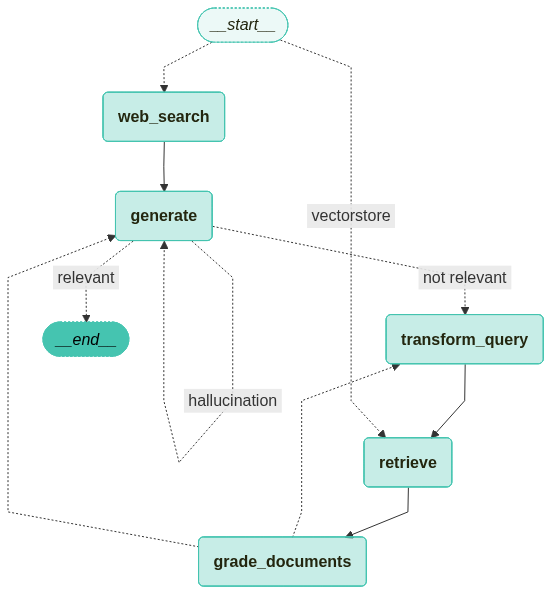

In [13]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(app)

### 그래프 사용

In [14]:
from langchain_teddynote.messages import stream_graph, random_uuid
from langchain_core.runnables import RunnableConfig

# config 설정(재귀 최대 횟수, thread_id)
config = RunnableConfig(recursion_limit=20, configurable={"thread_id": random_uuid()})

# 질문 입력
inputs = {
    "question": "삼성전자가 개발한 생성형 AI 의 이름은?",
}

# 그래프 실행
stream_graph(app, inputs, config, ["agent", "rewrite", "generate"])

==== [ROUTE QUESTION] ====
==== [ROUTE QUESTION TO VECTORSTORE] ====
==== [RETRIEVE] ====
==== [CHECK DOCUMENT RELEVANCE TO QUESTION] ====
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
==== [DECISION TO GENERATE] ====
==== [DECISION: GENERATE] ====
==== [GENERATE] ====

🔄 Node: generate 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
삼성전자가 개발한 생성형 AI의 이름은 '삼성 가우스'입니다.

**Source**
- data/SPRI_AI_Brief_2023년12월호_F.pdf (page 12)==== [CHECK HALLUCINATIONS] ====
{"binary_score":"yes"}==== [DECISION: GENERATION IS GROUNDED IN DOCUMENTS] ====
==== [GRADE GENERATED ANSWER vs QUESTION] ====
{"binary_score":"yes"}==== [DECISION: GENERATED ANSWER ADDRESSES QUESTION] ====
